
# Line Detection and Edge Detection

Prepared by **Mahabbat Zakariyayev** with **enthusiasm**

This notebook demonstrates two approaches for detecting linear structures (boundaries) in an image. The first approach uses a set of oriented convolution kernels to highlight edges in specific directions, while the second approach uses the Canny edge detector. Both methods are evaluated against a provided ground‐truth boundary mask using common segmentation metrics such as precision, recall, F1‑score, Intersection over Union (IoU) and balanced accuracy.



## Section 1 – Load and Preprocess Image

In this section we import the necessary libraries, load the sample image `P0061.png`( I have also applied other images for adding to the presentation), convert it to grayscale and apply Gaussian smoothing. Blurring reduces high‑frequency noise and improves the robustness of subsequent edge detection. A simple visualization of the grayscale image is also provided.


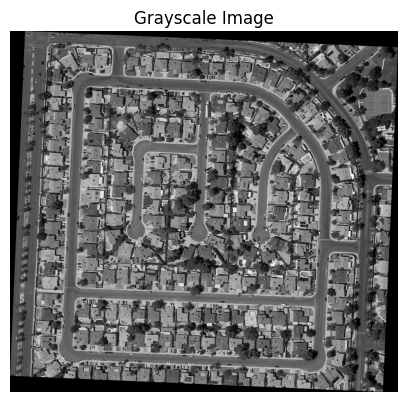

In [4]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# I have used cv2 to read the color image
img_bgr = cv2.imread("P0061.png")
# Converted to grayscale
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
# I have appplied Gaussian blur to reduce noize
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)
plt.figure(figsize=(5, 5))
plt.title("Grayscale Image")
plt.imshow(img_gray, cmap="gray")
plt.axis("off")
plt.show()



## Section 2 – Line Detection Using Oriented Kernels

To detect line structures in different orientations, we construct four \(3 	imes 3\) convolution kernels representing horizontal (0°), vertical (90°) and the two diagonal (45° and 135°) directions. We convolve each kernel with the blurred image and take the absolute response. The maximum response across all orientations indicates where a line is present regardless of its direction.

An adaptive threshold is created by using the 95th percentile to threshold the maximum response, and the predicted line map is formed of all pixels that have exceeded this threshold. The ground-truth boundary mask is created by using the provided instance mask to contain the object's boundaries, applying dilation and erosion. To quantify performance, we compute a variety of evaluation metrics.


TP, FP, FN, TN: 13485, 161862, 50057, 3326968
Precision: 0.0769
Recall: 0.2122
F1 Score (Dice): 0.1129
IoU: 0.0598
Accuracy: 0.9403
Specificity: 0.9536
FPR: 0.0464
FNR: 0.7878
Balanced Accuracy: 0.5829


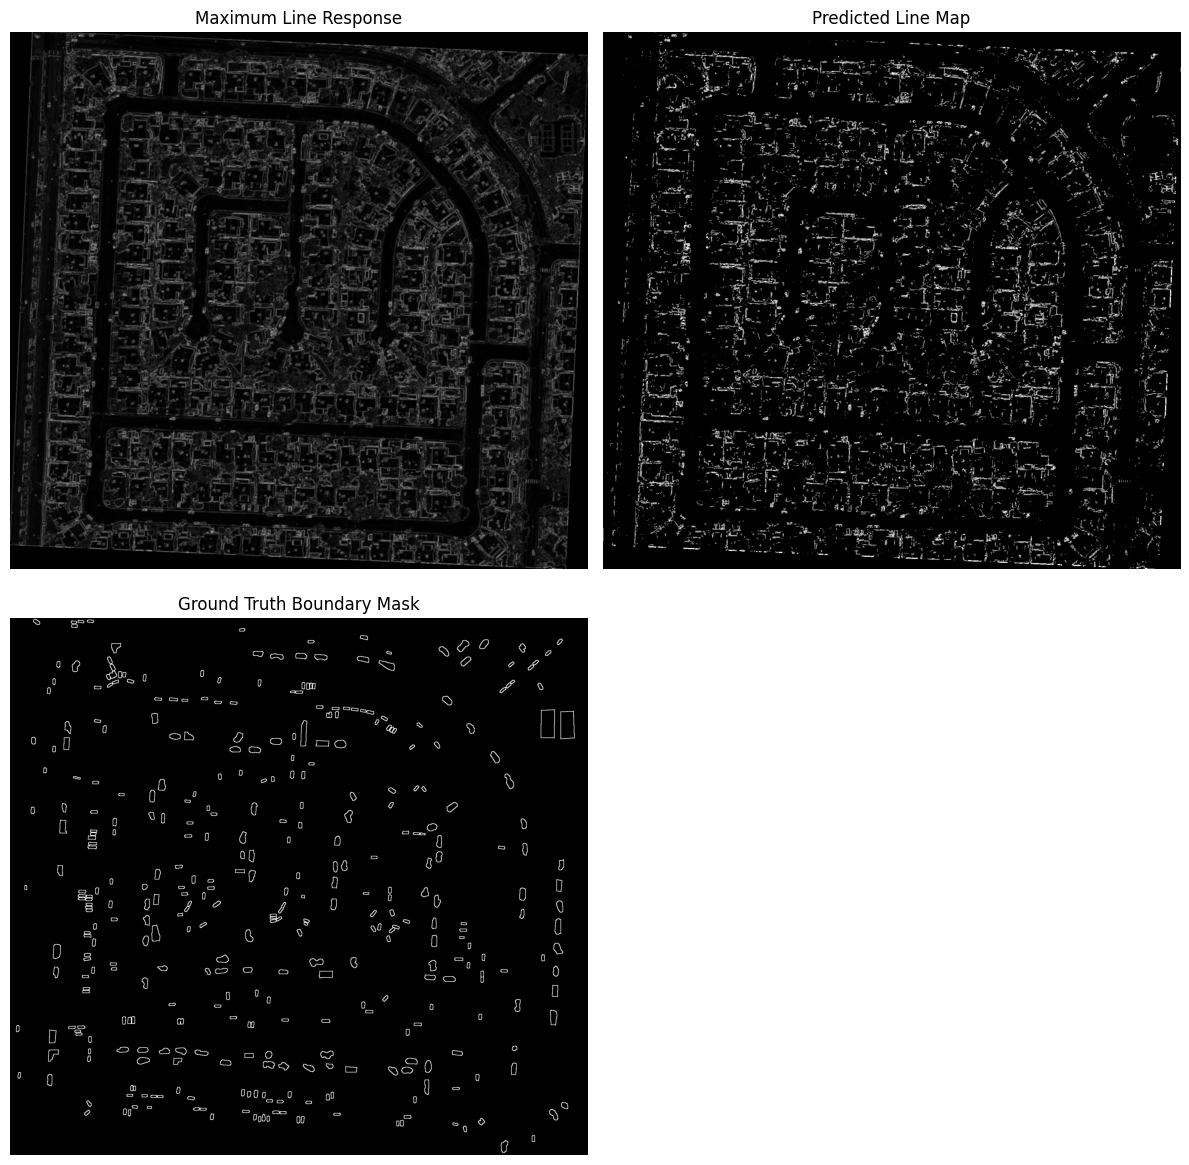

In [5]:

# Define oriented 3x3 kernels for line detection
k0 = np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]], dtype=np.float32)  # horizontal
k90 = np.array([[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]], dtype=np.float32)  # vertical
k45 = np.array([[-1, -1, 2], [-1, 2, -1], [2, -1, -1]], dtype=np.float32)  # 45 degrees diagonal
k135 = np.array([[2, -1, -1], [-1, 2, -1], [-1, -1, 2]], dtype=np.float32)  # 135 degrees diagonal
kernels = [k0, k45, k90, k135]

# Convolve each kernel with the blurred image
responses = [cv2.filter2D(img_blur, cv2.CV_32F, k) for k in kernels]
R0, R45, R90, R135 = responses

# Stack responses and take the maximum absolute response across all orientations
stacked = np.stack([np.abs(R0), np.abs(R45), np.abs(R90), np.abs(R135)], axis=-1)
R_max = np.max(stacked, axis=-1)

# Thresholded using the 95 percentile of the response values to obtain a binary line map below
T = np.percentile(R_max, 95)
line_map = (R_max > T).astype(np.uint8)

# Loaded the ground‑truth instance mask and compute a boundary mask after some retries
gt_raw = cv2.imread("images/P0061_instance_color_RGB.png", cv2.IMREAD_GRAYSCALE)
if gt_raw is None:
    raise FileNotFoundError("Could not load images/P0061_instance_color_RGB.png. Please ensure the ground‑truth mask is available.")

semantic = (gt_raw > 0).astype(np.uint8) * 255
kernel = np.ones((3, 3), np.uint8)
dil = cv2.dilate(semantic, kernel, iterations=1)
ero = cv2.erode(semantic, kernel, iterations=1)
gt = ((dil - ero) > 0).astype(np.uint8)

# Evaluate predicted line map against ground truth 
pred = line_map.astype(np.uint8)

TP = np.logical_and(pred == 1, gt == 1).sum()
FP = np.logical_and(pred == 1, gt == 0).sum()
FN = np.logical_and(pred == 0, gt == 1).sum()
TN = np.logical_and(pred == 0, gt == 0).sum()

precision = TP / (TP + FP + 1e-9)
recall    = TP / (TP + FN + 1e-9)
f1_score  = 2 * precision * recall / (precision + recall + 1e-9)
iou       = TP / (TP + FP + FN + 1e-9)
accuracy  = (TP + TN) / (TP + FP + FN + TN + 1e-9)
specificity = TN / (TN + FP + 1e-9)
dice = f1_score
fpr = FP / (FP + TN + 1e-9)
fnr = FN / (TP + FN + 1e-9)
balanced_accuracy = (recall + specificity) / 2

#Some(too many) print statements to show the metrics :)
print(f"TP, FP, FN, TN: {TP}, {FP}, {FN}, {TN}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score (Dice): {f1_score:.4f}")
print(f"IoU: {iou:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.title("Maximum Line Response")
plt.imshow(R_max, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Predicted Line Map")
plt.imshow(pred, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Ground Truth Boundary Mask")
plt.imshow(gt, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()



## Section 3 – Canny Edge Detection

The Canny operator is a classic multi‑stage edge detector. We first apply the same Gaussian blur used earlier to suppress noise. Then we call `cv2.Canny` with low and high thresholds to obtain a binary edge map. As before, we compare the predicted edges with the boundary mask and compute identical evaluation metrics. Varying the thresholds will adjust the sensitivity of the detector.


TP, FP, FN, TN: 19403, 454933, 44139, 3033897
Precision: 0.0409
Recall: 0.3054
F1 Score (Dice): 0.0721
IoU: 0.0374
Accuracy: 0.8595
Specificity: 0.8696
FPR: 0.1304
FNR: 0.6946
Balanced Accuracy: 0.5875


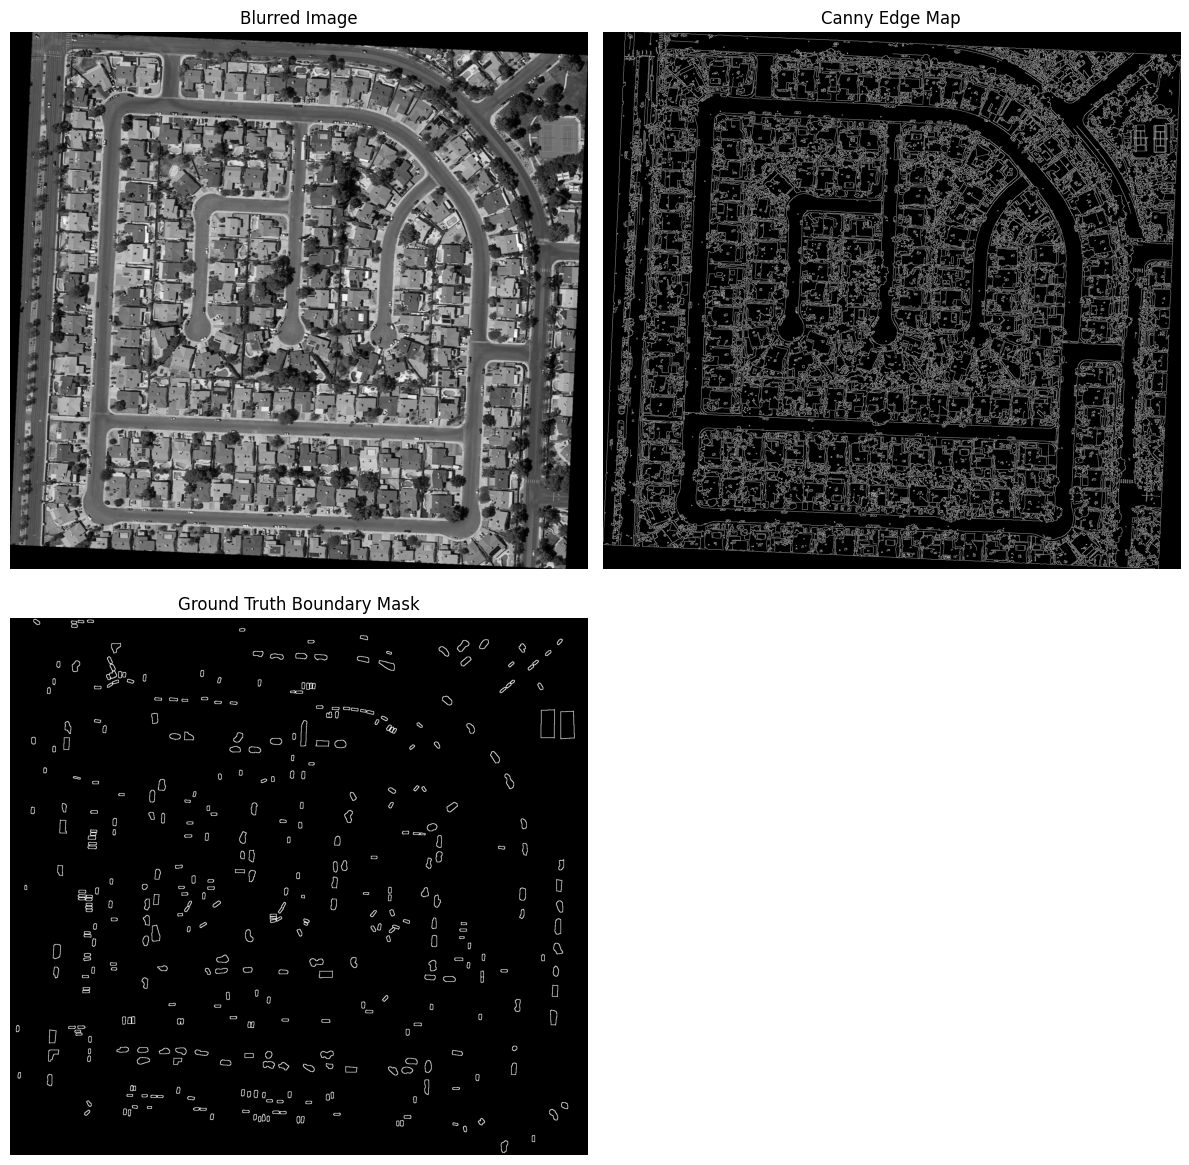

In [6]:

#I have defined low and high hysteresis thresholds for Canny
t_low = 50
t_high = 150

# I have Computed Canny edges on the blurred grayscale image
edges = cv2.Canny(img_blur, t_low, t_high)

# Converted the edge map to binary prediction mask
pred_canny = (edges > 0).astype(np.uint8)

# Evaluated the  predicted edges against the same ground truth boundary mask here 
TP = np.logical_and(pred_canny == 1, gt == 1).sum()
FP = np.logical_and(pred_canny == 1, gt == 0).sum()
FN = np.logical_and(pred_canny == 0, gt == 1).sum()
TN = np.logical_and(pred_canny == 0, gt == 0).sum()

precision = TP / (TP + FP + 1e-9)
recall    = TP / (TP + FN + 1e-9)
f1_score  = 2 * precision * recall / (precision + recall + 1e-9)
iou       = TP / (TP + FP + FN + 1e-9)
accuracy  = (TP + TN) / (TP + FP + FN + TN + 1e-9)
specificity = TN / (TN + FP + 1e-9)
fpr = FP / (FP + TN + 1e-9)
fnr = FN / (TP + FN + 1e-9)
balanced_accuracy = (recall + specificity) / 2

print(f"TP, FP, FN, TN: {TP}, {FP}, {FN}, {TN}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score (Dice): {f1_score:.4f}")
print(f"IoU: {iou:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"FNR: {fnr:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

# Visualizeed my resultws
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.title("Blurred Image")
plt.imshow(img_blur, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Canny Edge Map")
plt.imshow(pred_canny, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Ground Truth Boundary Mask") 
plt.imshow(gt, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()



## Conclusion
In this notebook, the Canny edge detector and a simple Oriented Kernel method were directly compared for detecting boundaries within a test image. While the Oriented Kernel method isolated edges based on their orientations and combined them together to build a skeleton of detected edges, the Canny edge detection process utilized gradient magnitude on the image and applied non-maximum suppression on these values, followed by thresholding to provide binary edge images. The results from both methods produced edge maps with accurate edge locations when using threshold values and kernel orientations that are properly set. As metrics such as Precision, Recall, F1-score, IoU, etc., are used to evaluate the Canny edge detector's performance, these metrics can be quantitatively compared with the true boundary masks to evaluate the quality of the Canny edge detector's edges.

Thank you for reading!
